In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from solardatatools import DataHandler
from spcqe.functions import make_basis_matrix

from utils.load_redshift_data import load_redshift_data
import utils.dilatation as dilatation

/var/folders/b5/mtl69w8n2n19ms1v6b8fvy5r0000gn/T/ipykernel_34117/2222548577.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Difference between np.mod and np.tile for non integer periods

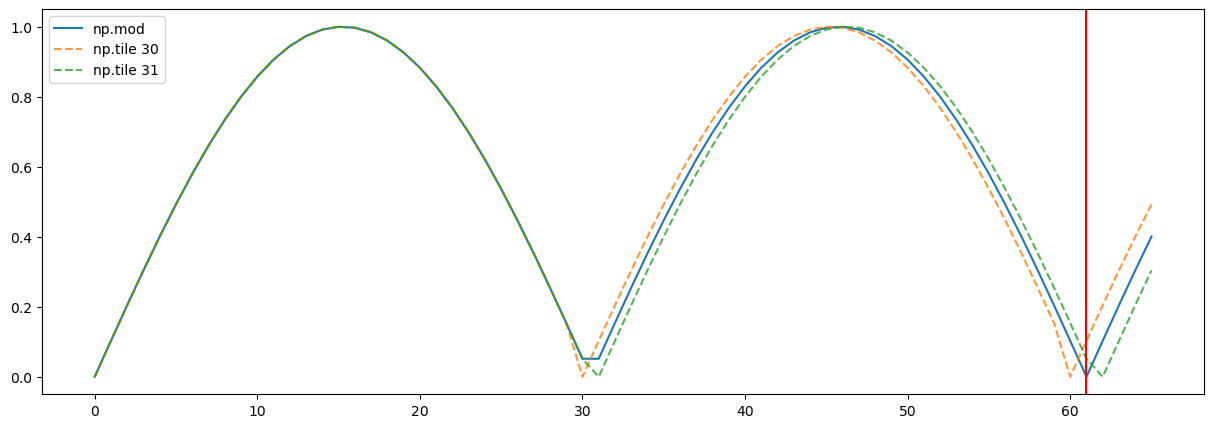

In [66]:
T = 30.5
N = int(2*T + 5)

t_values = np.arange(0, N, 1)

sig1 = np.sin(np.pi * np.mod(t_values, T) / T)
sig2 = np.sin(np.pi * t_values[:int(T)] / T)
multiplier = max(1, N // sig2.shape[0] + 1)
sig2 = np.tile(sig2, multiplier)[:N]
sig3 = np.sin(np.pi * t_values[:int(T)+1] / T)
multiplier = max(1, N // sig3.shape[0] + 1)
sig3 = np.tile(sig3, multiplier)[:N]

plt.figure(figsize=(15, 5))
plt.plot(t_values, sig1, label='np.mod')
plt.plot(t_values, sig2, label='np.tile ' + str(int(T)), linestyle='--', alpha=0.8)
plt.plot(t_values, sig3, label='np.tile ' + str(int(T)+1), linestyle='--', alpha=0.8)
plt.axvline(2*T, color='red')
plt.legend()
plt.show()

## Sample basis

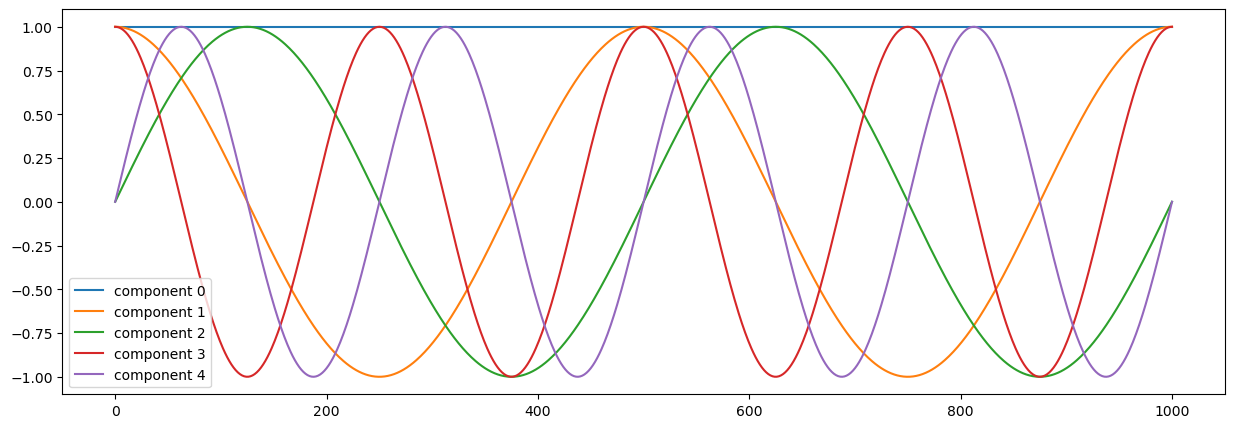

In [67]:
basis = make_basis_matrix(num_harmonics=2,
                           length=1000+1,
                           periods=500,
                           standing_wave=False,
                           trend=False,
                           max_cross_k=None,
                           custom_basis=None)
plt.figure(figsize=(15, 5))
for i in range(basis.shape[1]):
    plt.plot(basis[:, i], label=f'component {i}')
plt.legend()
plt.show()

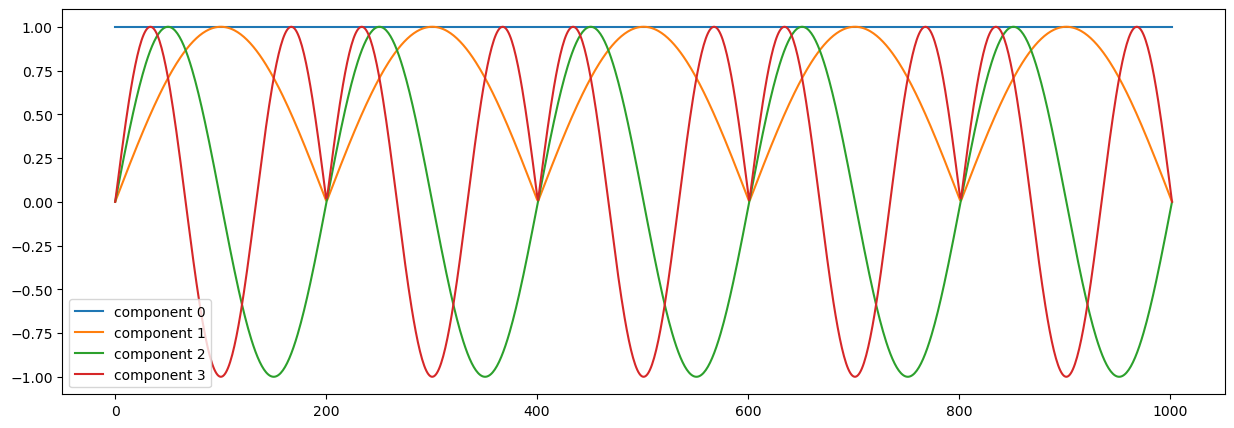

In [69]:
basis = make_basis_matrix(num_harmonics=3,
                           length=1002+1,
                           periods=200.4,
                           standing_wave=True,
                           trend=False,
                           max_cross_k=None,
                           custom_basis=None)
plt.figure(figsize=(15, 5))
for i in range(basis.shape[1]):
    plt.plot(basis[:, i], label=f'component {i}')
plt.legend()
plt.show()

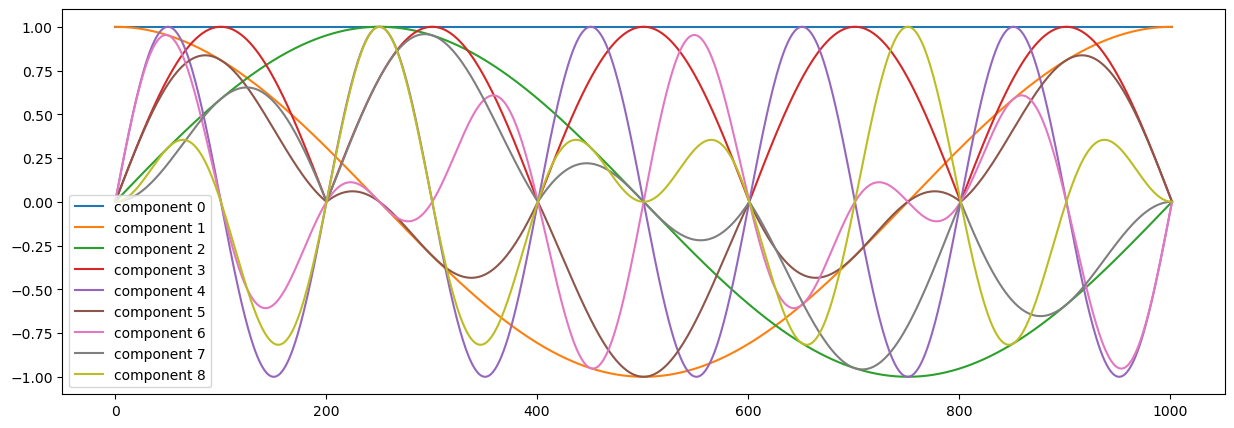

In [70]:
basis = make_basis_matrix(num_harmonics=[2, 1],
                          length=1002+1,
                          periods=[200.4, 1002],
                          standing_wave=[True, False],
                          trend=False,
                          max_cross_k=None,
                          custom_basis=None)
plt.figure(figsize=(15, 5))
for i in range(basis.shape[1]):
    plt.plot(basis[:, i], label=f'component {i}')
plt.legend()
plt.show()

## With PV data

In [6]:
query = {
'siteid': "TADBC1078041",
'api_key': os.environ.get('REDSHIFT_API_KEY'),
'sensor': 0
}
df = load_redshift_data(**query)
dh = DataHandler(df, convert_to_ts=True)
dh.run_pipeline()

/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/time_axis_manipulation.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  meas_name = str(df_view[name_key][0])
/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/time_axis_manipulation.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if avg_day[0] >= thresh:
/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/time_axis_manipulation.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

total time: 55.69 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              12.85s
Cleaning                   0.67s
Filtering/Summarizing      42.16s
    Data quality           0.39s
    Clear day detect       0.82s
    Clipping detect        21.22s
    Capacity change detect 19.73s



In [7]:
# For now, dilatation can not handle NaNs. We us the filled data matrix, dilate, then add the NaNs again. It will change it soon.
signal_series = pd.Series(
    data= dh.filled_data_matrix.ravel(order='F') / dh.capacity_estimate,
    index = dh.data_frame.index
    )
sunrises = dh.daytime_analysis.sunrise_estimates
sunsets = dh.daytime_analysis.sunset_estimates

In [8]:
nvals_ori = dh.raw_data_matrix.shape[0]
nvals_dil = 101
ndays = 700

In [9]:
# Dilatation
# Indexes have 1 more value than the signals (the right boundary of the last bin)
idx_ori = dilatation.build_original_idx(signal_series, nvals_ori)
idx_dil = dilatation.build_dilated_idx(sunrises, sunsets, idx_ori, nvals_dil)
signal_ori = signal_series.to_numpy()
signal_dil = dilatation.dilate_signal(idx_dil, idx_ori, signal_ori)

In [10]:
# Add NaNs again
_sig = signal_ori.reshape((nvals_ori, dh.raw_data_matrix.shape[1]), order='F')
nan_mask_ori = np.tile(dh.daily_flags.no_errors, (nvals_ori, 1))
_sig[~nan_mask_ori] = np.nan
signal_ori = _sig.ravel(order='F')

_sig = signal_dil[1:].reshape((nvals_dil, dh.raw_data_matrix.shape[1]), order='F')
nan_mask_dil = np.tile(dh.daily_flags.no_errors, (nvals_dil, 1))
_sig[~nan_mask_dil] = np.nan
signal_dil[1:] = _sig.ravel(order='F')

In [11]:
# Crop
idx_ori = idx_ori[0*nvals_ori:ndays*nvals_ori+2] # starts at the first midnight, ends 24h/nvlas_ori after the ndays-th midnight
signal_ori = signal_ori[0*nvals_ori:ndays*nvals_ori+1]
idx_dil = idx_dil[0*nvals_dil:ndays*nvals_dil+2]  # starts at the first midnight, ends at the first sunrise after the ndays-th midnight
signal_dil = signal_dil[0*nvals_dil:ndays*nvals_dil+1]

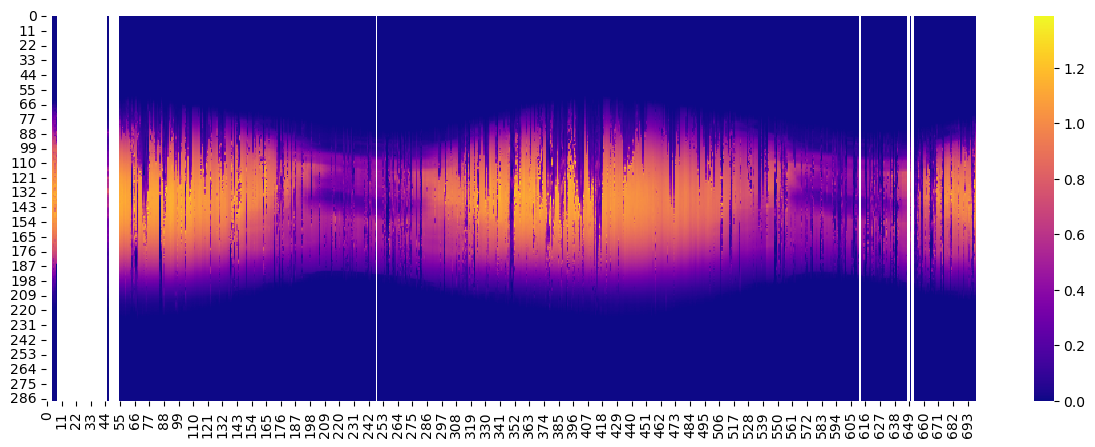

In [71]:
plt.figure(figsize=(15, 5))
sns.heatmap(signal_ori[:-1].reshape((nvals_ori, ndays), order='F'), cmap='plasma');

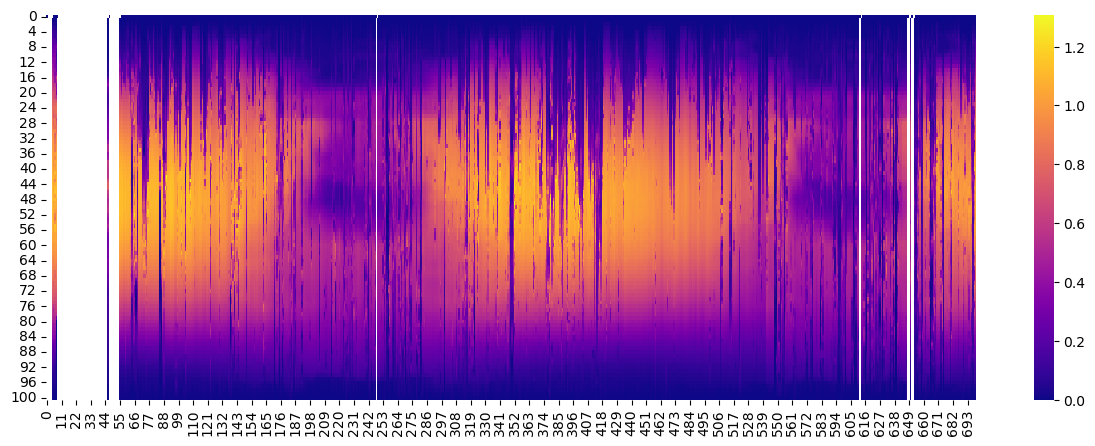

In [72]:
plt.figure(figsize=(15, 5))
sns.heatmap(signal_dil[:-1].reshape((nvals_dil, ndays), order='F'), cmap='plasma');

In [14]:
regular_basis = make_basis_matrix(
    num_harmonics=[2, 2],
    length=signal_dil.shape[0],
    periods=[nvals_dil, 365.24225*nvals_dil],
    standing_wave=False,
    trend=False,
    max_cross_k=None,
    custom_basis=None
)

In [15]:
standing_wave_basis = make_basis_matrix(
    num_harmonics=[4, 2],
    length=signal_dil.shape[0],
    periods=[nvals_dil, 365.24225*nvals_dil],
    standing_wave=[True, False],
    trend=False,
    max_cross_k=None,
    custom_basis=None
)

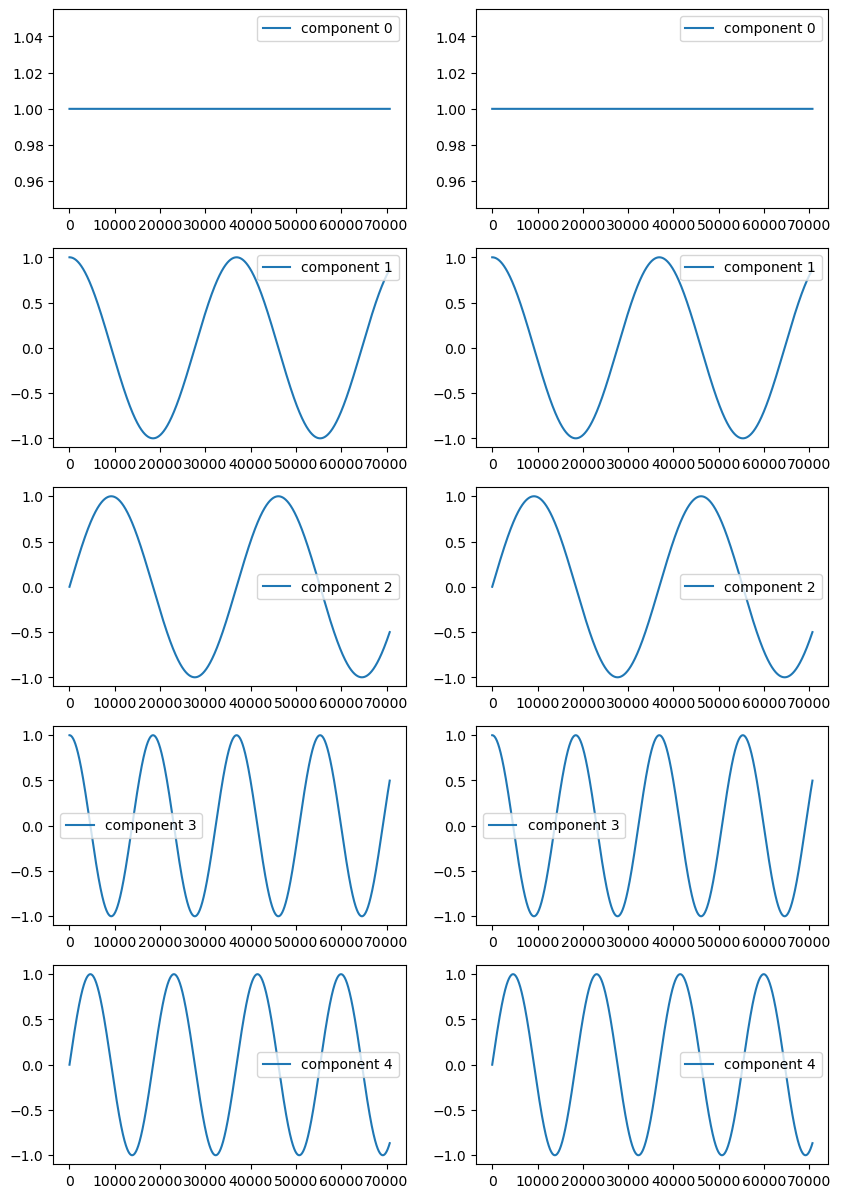

In [16]:
fig, ax = plt.subplots(5, 2, figsize=(10, 15))
for i in range(5):
    ax[i, 0].plot(regular_basis[:, i], label=f'component {i}')
    ax[i, 1].plot(standing_wave_basis[:, i], label=f'component {i}')
    ax[i, 0].legend()
    ax[i, 1].legend()
plt.show()

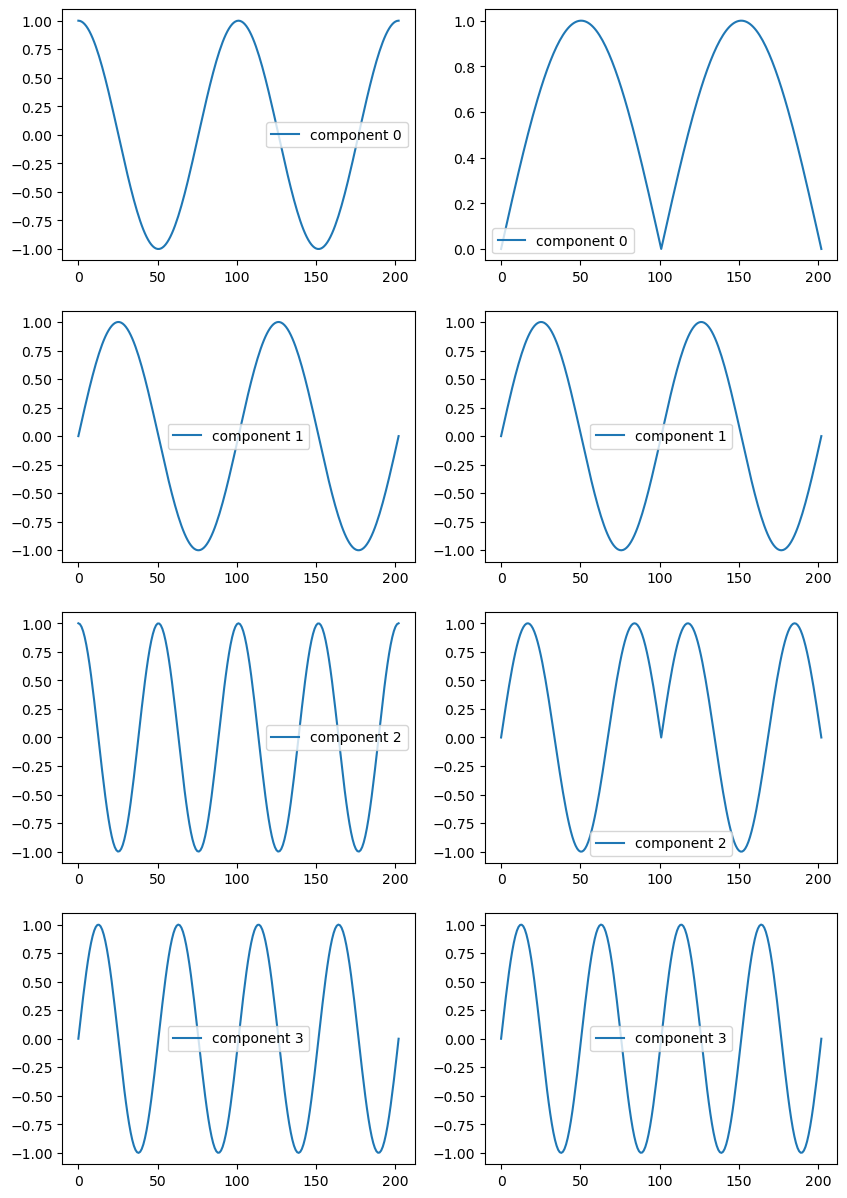

In [17]:
fig, ax = plt.subplots(4, 2, figsize=(10, 15))
for i in range(4):
    ax[i, 0].plot(regular_basis[0:nvals_dil*2 + 1, i+5], label=f'component {i}')
    ax[i, 1].plot(standing_wave_basis[0:nvals_dil*2 + 1, i+5], label=f'component {i}')
    ax[i, 0].legend()
    ax[i, 1].legend()
plt.show()

## Checking if custom basis works

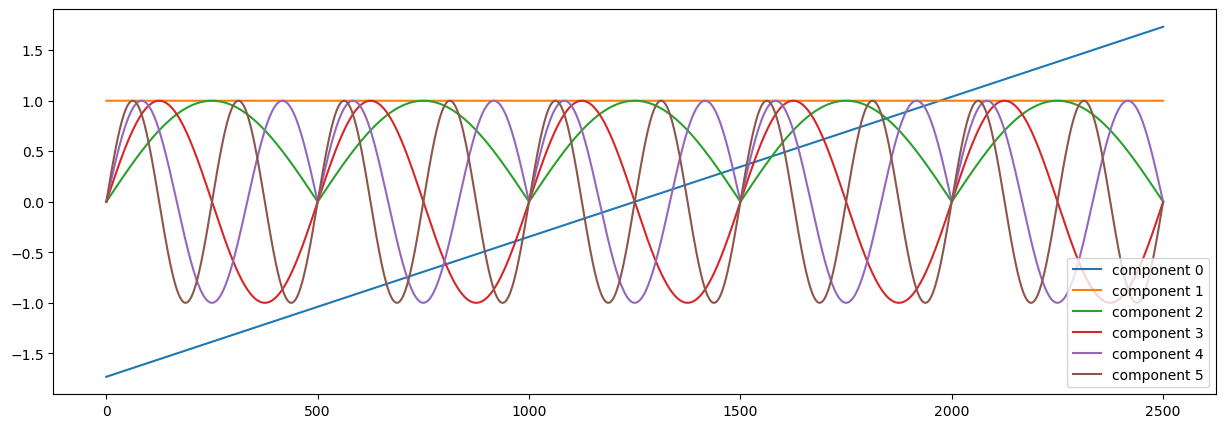

In [73]:
basis1 = make_basis_matrix(num_harmonics=4,
                           length=2500+1,
                           periods=500,
                           standing_wave=True,
                           trend=True,
                           max_cross_k=None,
                           custom_basis=None)
plt.figure(figsize=(15, 5))
for i in range(basis1.shape[1]):
    plt.plot(basis1[:, i], label=f'component {i}')
plt.legend()
plt.show()

In [19]:
def make_sine_only_basis(length, period, num_harmonics, tstart=0):
    w = 2 * np.pi / (period * 2)
    i_value = np.arange(1, num_harmonics + 1)[:, np.newaxis]
    t_values = np.arange(period) + tstart
    B_sin = np.sin(i_value * w * t_values).T
    B_fourier = np.empty((length, num_harmonics), dtype=float)
    multiplier = max(1, length // B_sin.shape[0] + 1)
    B_fourier = np.tile(B_sin, (multiplier, 1))[:length]
    return B_fourier

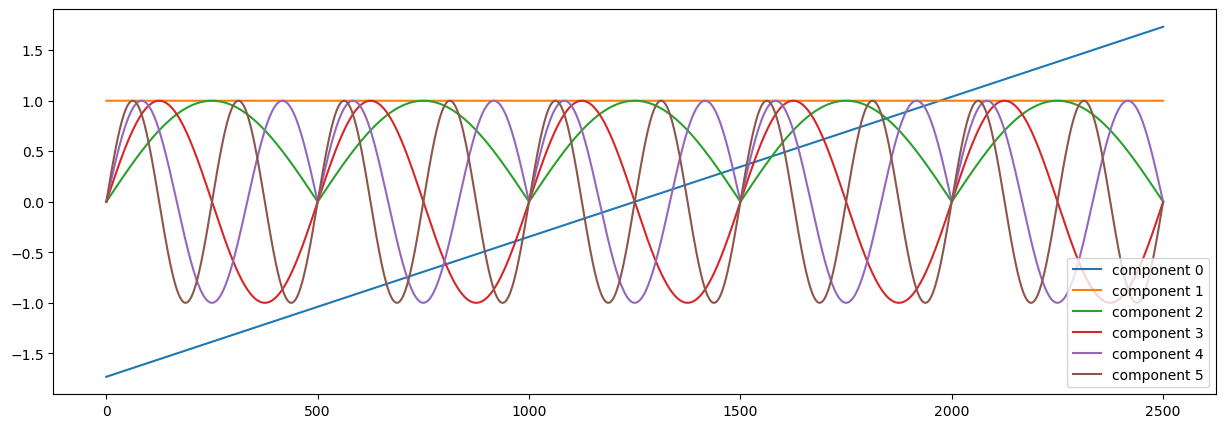

In [74]:
my_custom_basis = make_sine_only_basis(500, 500, 4)
basis2 = make_basis_matrix(num_harmonics=1,
                           length=2500+1,
                           periods=10,
                           standing_wave=False,
                           trend=True,
                           max_cross_k=None,
                           custom_basis={0: my_custom_basis})
plt.figure(figsize=(15, 5))
for i in range(basis2.shape[1]):
    plt.plot(basis2[:, i], label=f'component {i}')
plt.legend()
plt.show()

In [23]:
(basis1==basis2).all()

True